# Got Scotch?

In this notebook, we're going to create a dashboard that recommends scotches based on their taste profiles. 

We will have a short intro line indicating which scotch you're examining, followed by a dropdown of all the scotches to pick from. Then on the selection of a scotch, a recommendation table will display the top 5 most similar scotches to your original selection. We will also have a radar chart to show this scotch's taste profile. You can also click on one of the recommendations to examine further in the radar chart this scotch's taste profile compared to your original selection.

To do this, we'll use ipywidgets and jupyter_dashboards.

On your first visit to this notebook, we recommend that you execute one cell at a time as you read along. Later, if you just want to see the demo, select _Cell_ > _Run All_ from the menu bar. Once you've run all of the cells, select _View_ > _View Dashboard_ and then select a scotch to see the similar recommendations. Click on a similar scotch to examine how it's compared to your original selection.

__Table of Contents__
1. [Load features and similarities data](#Load-Data-Top)
2. [Set up Radar Visualization](#Radar-Visualization-Top)
3. [Set up Dashboard](#Dashboard-Setup-Top)
4. [Arrange Dashboard Layout](#Arrange-the-Dashboard-Layout-Top)


In [5]:
%matplotlib inline

In [6]:
import pandas as pd
import seaborn as sns
import os

In [7]:
import ipywidgets as widgets
from traitlets import Unicode, List, Instance, link
from IPython.display import display, clear_output, HTML, Javascript
import jinja2

## Load Data <span style="float: right; font-size: 0.5em"><a href="#Got-Scotch?">Top</a></span>

In [8]:
features_df = pd.read_pickle('./datasets/features.dataframe')
sim_df = pd.read_pickle('./datasets/sims.dataframe')

We will drop the cluster column from *features\_df*. We don't need it here.

In [9]:
features_df = features_df.drop('cluster', axis=1)

## Radar Visualization <span style="float: right; font-size: 0.5em"><a href="#Got-Scotch?">Top</a></span>

Shamelessly copy/pasting the http://matplotlib.org/examples/api/radar_chart.html example here as a visualization.

In [10]:
"""
Example of creating a radar chart (a.k.a. a spider or star chart) [1]_.

Although this example allows a frame of either 'circle' or 'polygon', polygon
frames don't have proper gridlines (the lines are circles instead of polygons).
It's possible to get a polygon grid by setting GRIDLINE_INTERPOLATION_STEPS in
matplotlib.axis to the desired number of vertices, but the orientation of the
polygon is not aligned with the radial axes.

.. [1] http://en.wikipedia.org/wiki/Radar_chart
"""
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib.spines import Spine
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection


def radar_factory(num_vars, frame='circle'):
    """Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle' | 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = 2*np.pi * np.linspace(0, 1-1./num_vars, num_vars)
    # rotate theta such that the first axis is at the top
    theta += np.pi/2

    def draw_poly_patch(self):
        verts = unit_poly_verts(theta)
        return plt.Polygon(verts, closed=True, edgecolor='k')

    def draw_circle_patch(self):
        # unit circle centered on (0.5, 0.5)
        return plt.Circle((0.5, 0.5), 0.5)

    patch_dict = {'polygon': draw_poly_patch, 'circle': draw_circle_patch}
    if frame not in patch_dict:
        raise ValueError('unknown value for `frame`: %s' % frame)

    def rand_jitter(arr):
        stdev = .01*(max(arr)-min(arr))
        return arr + np.random.randn(len(arr)) * stdev
        
    class RadarAxes(PolarAxes):

        name = 'radar'
        # use 1 line segment to connect specified points
        RESOLUTION = 1
        # define draw_frame method
        draw_patch = patch_dict[frame]

        def fill(self, *args, **kwargs):
            """Override fill so that line is closed by default"""
            closed = kwargs.pop('closed', True)
            return super(RadarAxes, self).fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super(RadarAxes, self).plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.concatenate((x, [x[0]]))
                y = np.concatenate((y, [y[0]]))
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(theta * 180/np.pi, labels)

        def _gen_axes_patch(self):
            return self.draw_patch()

        def _gen_axes_spines(self):
            if frame == 'circle':
                return PolarAxes._gen_axes_spines(self)
            # The following is a hack to get the spines (i.e. the axes frame)
            # to draw correctly for a polygon frame.

            # spine_type must be 'left', 'right', 'top', 'bottom', or `circle`.
            spine_type = 'circle'
            verts = unit_poly_verts(theta)
            # close off polygon by repeating first vertex
            verts.append(verts[0])
            path = Path(verts)

            spine = Spine(self, spine_type, path)
            spine.set_transform(self.transAxes)
            return {'polar': spine}

    register_projection(RadarAxes)
    return theta


def unit_poly_verts(theta):
    """Return vertices of polygon for subplot axes.

    This polygon is circumscribed by a unit circle centered at (0.5, 0.5)
    """
    x0, y0, r = [0.5] * 3
    verts = [(r*np.cos(t) + x0, r*np.sin(t) + y0) for t in theta]
    return verts

In [11]:
def radar(df):
    theta = radar_factory(len(df.columns), frame='polygon')
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(2, 2, 1, projection='radar')
    for d, color in zip(df.itertuples(), sns.color_palette()):
        ax.plot(theta, d[1:], color=color, alpha=0.7)
        ax.fill(theta, d[1:], facecolor=color, alpha=0.5)
    ax.set_varlabels(df.columns)
    plt.rgrids([1, 2, 3, 4])
    legend = plt.legend(df.index, loc=(0.9, .95))

### Radar Widget

Now we'll define a new, custom ipywidgets.DOMWidget to serve as a Python backend for our new radar chart. In this visualization, we will call taste features like smokey, winey, honey, etc. "factors", and the scotch that we use to look up the factors a "factors_key".

We want this radar widget to update when the selected scotch changes, meaning when user selects a new scotch, or when they click on a similar recommended scotch to compare to the original selection. We then draw the taste profiles of these scotches into a radar chart by calling the _radar( )_ function defined above.

In [12]:
class RadarWidget(widgets.DOMWidget):
    _view_name = Unicode('RadarView').tag(sync=True)
    _view_module = Unicode('radar').tag(sync=True)
    factors_keys = List(['Aberfeldy']).tag(sync=True)
    
    def __init__(self, df, **kwargs):
        self.df = df
        super(RadarWidget, self).__init__(**kwargs)
        self._factors_keys_changed('', self.factors_keys, self.factors_keys)
    
    def _factors_keys_changed(self, name, old_value, new_value):
        clear_output(wait=True)
        return radar(self.df.loc[new_value])

### Radar View

Next, we need to define a RadarView that serves as the front-end view for the Python widget class we defined above. This frontend will contain the Javascript that watches for events in the similarities/recommendations table and redraws the radar plot accordingly.

In [13]:
%%javascript
require.undef('radar');

define('radar', ["jupyter-js-widgets", "base/js/events"], function(widgets, events) {
    var RadarView = widgets.DOMWidgetView.extend({
        render: function() {
            var that = this;
            events.on('select.factors_keys', function(event, data) {
                if(data.factors_keys) {
                    that.model.set('factors_keys', data.factors_keys);
                    that.touch();
                }
            });
        }
    });
    return {
        RadarView: RadarView
    }
});

<IPython.core.display.Javascript object>

## Dashboard Setup <span style="float: right; font-size: 0.5em"><a href="#Got-Scotch?">Top</a></span>

Finally, we will set up the dashboard to show a short introduction line about which scotch you're examining, then a scotch dropdown picker, a recommendation table, and a radar chart to show how similar it is to your selection.

We need to add an *on click* event on the recommended scotch links. On click, the event will trigger the Radar View's *select.factors* event.

In [14]:
%%javascript
$(document).off('click', 'a.scotch');
$(document).on('click', 'a.scotch', function(event) {
    var data = $(event.target).data();
    IPython.notebook.events.trigger('select.factors_keys', data);
});

<IPython.core.display.Javascript object>

In [15]:
%%html
<style>
table.dataframe {
    width: 100%
}
iframe.wiki {
    width: 100%;
    height: 400px;
}
</style>

We then need a short intro line template, let's assign it to a variable called _tmpl_.

In [16]:
tmpl = jinja2.Template('''<p>If you like {{name}} you might want to try these five brands. Click one to see how its taste profile compares.</p>''')

We now define a *get_similar( )* function to return the data of the top n similar scotches to a given scotch.

In [17]:
def get_similar(name, n, top=True):
    a = sim_df[name].sort_values(ascending=False)
    a.name = 'Similarity'
    df = pd.DataFrame(a) #.join(features_df).iloc[start:end]
    return df.head(n) if top else df.tail(n)

We also need a function *on_pick_scotch* that will display a table of the top 5 similar scotches that Radar View watches, based on a given selected Scotch.

In [18]:
def on_pick_scotch(Scotch):
    name = Scotch
    # Get top 6 similar whiskeys, and remove this one
    top_df = get_similar(name, 6).iloc[1:]
    # Get bottom 5 similar whiskeys
#     bottom_df = get_similar(name, 5, False)
#     df = pd.concat([top_df, bottom_df])
    df = top_df
    
    # Make table index a set of links that the radar widget will watch
    df.index = ['''<a class="scotch" href="#" data-factors_keys='["{}","{}"]'>{}</a>'''.format(name, i, i) for i in df.index]
    
    prompt_w.value = tmpl.render(name=name)
    html = HTML(df.to_html(escape=False))
    js = Javascript("IPython.notebook.events.trigger('select.factors_keys', {factors_keys: ['%s']});" % name)
    
    return display(html, js)

Now we can render the previously assigned __tmpl__ with an argument _name_ as our first scotch 'Aberfeldy'. This is a default scotch, and the template will re-render when user picks a new scotch from the drop down.

In [19]:
prompt_w = widgets.HTML(value=tmpl.render(name='Aberfeldy'))
prompt_w

HTML(value='<p>If you like Aberfeldy you might want to try these five brands. Click one to see how its taste profile compares.</p>')

After that, we will render the scotch drop down picker, which will call our previously defined *on_scotch_picker* function when a new selection is made, and a similarities table will render accordingly.

In [20]:
picker_w = widgets.interact(on_pick_scotch, Scotch=list(sim_df.index))

interactive(children=(Dropdown(description='Scotch', options=('Aberfeldy', 'Aberlour', 'AnCnoc', 'Ardbeg', 'Ardmore', 'ArranIsleOf', 'Auchentoshan', 'Auchroisk', 'Aultmore', 'Balblair', 'Balmenach', 'Belvenie', 'BenNevis', 'Benriach', 'Benrinnes', 'Benromach', 'Bladnoch', 'BlairAthol', 'Bowmore', 'Bruichladdich', 'Bunnahabhain', 'Caol Ila', 'Cardhu', 'Clynelish', 'Craigallechie', 'Craigganmore', 'Dailuaine', 'Dalmore', 'Dalwhinnie', 'Deanston', 'Dufftown', 'Edradour', 'GlenDeveronMacduff', 'GlenElgin', 'GlenGarioch', 'GlenGrant', 'GlenKeith', 'GlenMoray', 'GlenOrd', 'GlenScotia', 'GlenSpey', 'Glenallachie', 'Glendronach', 'Glendullan', 'Glenfarclas', 'Glenfiddich', 'Glengoyne', 'Glenkinchie', 'Glenlivet', 'Glenlossie', 'Glenmorangie', 'Glenrothes', 'Glenturret', 'Highland Park', 'Inchgower', 'Isle of Jura', 'Knochando', 'Lagavulin', 'Laphroig', 'Linkwood', 'Loch Lomond', 'Longmorn', 'Macallan', 'Mannochmore', 'Miltonduff', 'Mortlach', 'Oban', 'OldFettercairn', 'OldPulteney', 'RoyalBrackla', 'RoyalLochnagar', 'Scapa', 'Speyburn', 'Speyside', 'Springbank', 'Strathisla', 'Strathmill', 'Talisker', 'Tamdhu', 'Tamnavulin', 'Teaninich', 'Tobermory', 'Tomatin', 'Tomintoul', 'Tormore', 'Tullibardine'), value='Aberfeldy'), Output()), _dom_classes=('widget-interact',))

And lastly, we construct a RadarWidget to display a radar chart showing the selected scotches taste profiles.

RadarWidget(factors_keys=['Aberfeldy'])

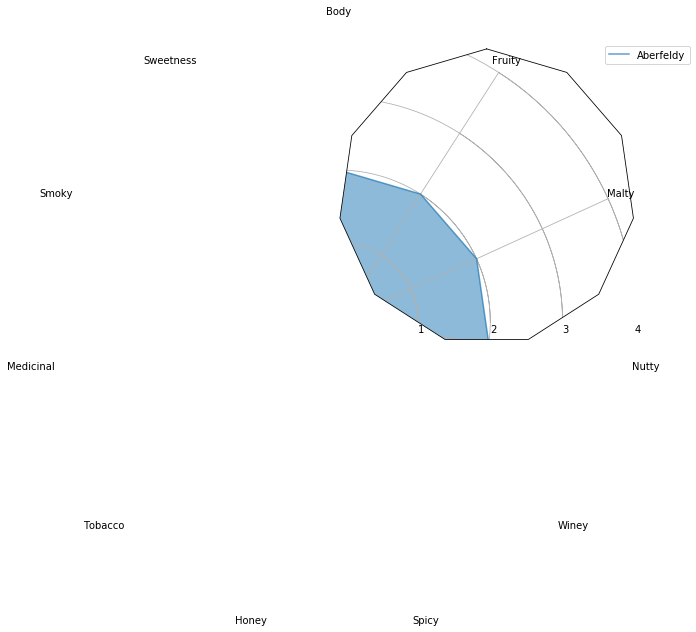

In [21]:
radar_w = RadarWidget(df=features_df)
radar_w

And finally, we'll include a footer in our dashboard with some attribution information.

Powered by data from https://www.mathstat.strath.ac.uk/outreach/nessie/nessie_whisky.html and inspired by analysis from http://blog.revolutionanalytics.com/2013/12/k-means-clustering-86-single-malt-scotch-whiskies.html. This dashboard originated as a Jupyter Notebook.

## Arrange the Dashboard Layout <span style="float: right; font-size: 0.5em"><a href="#Got-Scotch?">Top</a></span>


Select *View > Dashboard Preview* from the menu bar to see the dashboard view now. To return to the regular notebook view, select *View > Notebook*.

If you want to arrange the notebook cells differently, select *View > Dashboard Layout*. Then, hover your mouse over the main notebook / dashboard area. When you do, you'll see icons appear that allow you to:

- Drag cells to new locations
- Resize cells
- Show / hide cells in the dashboard view
- Flip to editing mode for a cell

Save the notebook to save your changes to the layout within the notebook file itself.

<div class="alert alert-info" role="alert" style="margin-top: 10px">
<p><strong>Note</strong><p>

<p>in a fresh notebook, the dashboard will only show cells with non-empty output. All other cells can be found in the *Hidden* section at the bottom of the dashboard layout page. You can quickly add all cell outputs or remove all cell outputs from the dashboard using the show / hide icons that appear in the notebook toolbar when you are in layout mode.</p>
</div>